# Developing an AI for Hand Gesture Recognition

You are working for a gaming company developing interactive AI-powered games. Your task is to create a hand gesture recognition model to play a game of Rock, Paper, Scissors against human players. The model should be accurate and able to predict gestures from images in real-time.

The Rock, Paper, Scissors dataset, available in TensorFlow Datasets, contains RGB images of hands showing rock, paper, and scissors gestures. Your goal is to create a model using transfer learning and test its real-time application potential.

# **ChatGPT**

## Step 1: Import Libraries

We begin by importing all the necessary libraries, including TensorFlow, matplotlib for visualization, TensorFlow Datasets for loading the Rock-Paper-Scissors dataset, and MobileNetV2 for transfer learning.

In [33]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

## Step 2: Load and Explore the Dataset

## We load the Rock-Paper-Scissors dataset using TensorFlow Datasets. The dataset contains RGB images categorized into three classes: rock, paper, and scissors. We also visualize a few samples.

Dataset Info: tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_dir='/root/tensorflow_datasets/rock_paper_scissors/3.0.0',
    file_format=tfrecord,
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemo

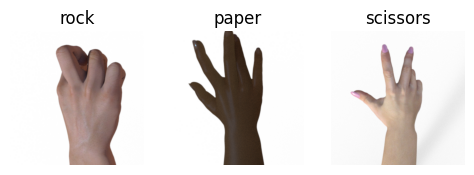

In [34]:
# Load Rock, Paper, Scissors Dataset
dataset, info = tfds.load('rock_paper_scissors', as_supervised=True, with_info=True)

# Split Dataset into Train and Test
train_dataset = dataset['train']
test_dataset = dataset['test']

# Print Dataset Information
print("Dataset Info:", info)
print(f"Number of training examples: {info.splits['train'].num_examples}")
print(f"Number of test examples: {info.splits['test'].num_examples}")
print("Classes:", info.features['label'].names)

# Visualize Sample Images
plt.figure(figsize=(10, 5))
for example in train_dataset.take(10):
    image, label = example
    plt.subplot(2, 5, label.numpy() + 1)
    plt.imshow(image)
    plt.title(info.features['label'].names[label.numpy()])
    plt.axis('off')
plt.show()

## Step 3: Preprocess the Data

We resize all images to (160, 160), normalize pixel values to the [0, 1] range, and batch the data. This is essential for training with the MobileNetV2 model.

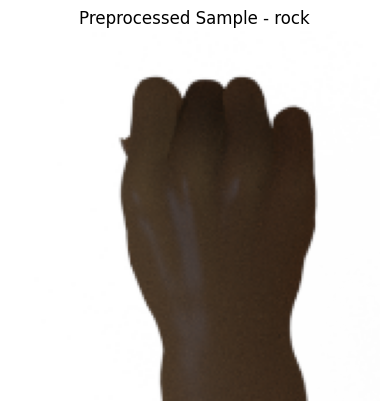

Image shape: (160, 160, 3)


In [35]:
IMG_SIZE = (160, 160)
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_dataset.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_dataset.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Visualize preprocessed sample
for images, labels in train_ds.take(1):
    plt.imshow(images[0].numpy())
    plt.title(f"Preprocessed Sample - {info.features['label'].names[labels[0].numpy()]}")
    plt.axis('off')
    plt.show()
    print("Image shape:", images[0].shape)


## Step 4: Build the Transfer Learning Model (with Hyperparameter Tuning)

To improve the model's performance, we implemented manual hyperparameter tuning by testing:
- Dropout rates: 0.3, 0.4, 0.5
- Dense layer sizes: 64, 128
- Optimizers: Adam, RMSprop

Each combination was trained for 5 epochs, and the best configuration was selected based on validation accuracy.


In [45]:
# Load base model
base_model = MobileNetV2(input_shape=(160, 160, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Build final model
def create_model(dropout_rate=0.3, dense_units=128, optimizer='adam'):
    base_model = MobileNetV2(input_shape=(160, 160, 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(dense_units, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [46]:
# 🔁 TRY MULTIPLE CONFIGURATIONS
params = [
    {'dropout_rate': 0.3, 'dense_units': 128, 'optimizer': 'adam'},
    {'dropout_rate': 0.5, 'dense_units': 64, 'optimizer': 'adam'},
    {'dropout_rate': 0.4, 'dense_units': 128, 'optimizer': 'RMSprop'}
]

results = []

for i, p in enumerate(params):
    print(f"\n🔁 Trial {i+1}: {p}")
    model = create_model(**p)
    history = model.fit(train_ds, validation_data=test_ds, epochs=5)
    val_acc = history.history['val_accuracy'][-1]
    results.append((p, val_acc))


🔁 Trial 1: {'dropout_rate': 0.3, 'dense_units': 128, 'optimizer': 'adam'}
Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 113ms/step - accuracy: 0.8846 - loss: 0.2999 - val_accuracy: 0.9409 - val_loss: 0.1458
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9982 - loss: 0.0124 - val_accuracy: 0.9704 - val_loss: 0.0777
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 1.0000 - loss: 0.0052 - val_accuracy: 1.0000 - val_loss: 0.0317
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9997 - loss: 0.0032 - val_accuracy: 1.0000 - val_loss: 0.0482
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9986 - loss: 0.0055 - val_accuracy: 0.9731 - val_loss: 0.0925

🔁 Trial 2: {'dropout_rate': 0.5, 'dense_units': 64, 'optimizer': 'adam'}
Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 121ms/step - accuracy: 0.8315 - loss: 0.3979 - val_accuracy: 0.9489 - val_loss: 0.1508
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9878 - loss: 0.0375 - val_a

In [47]:
# ✅ IDENTIFY BEST COMBINATION
best_config = max(results, key=lambda x: x[1])
print(f"\n✅ Best configuration: {best_config[0]} with validation accuracy: {best_config[1]:.4f}")


✅ Best configuration: {'dropout_rate': 0.3, 'dense_units': 128, 'optimizer': 'adam'} with validation accuracy: 0.9731


## Step 5: Train the Model

We train the model for 10 epochs using the training dataset, validating on the test dataset.

In [37]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10
)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 149ms/step - accuracy: 0.9006 - loss: 0.2616 - val_accuracy: 0.8978 - val_loss: 0.2592
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9967 - loss: 0.0123 - val_accuracy: 0.9677 - val_loss: 0.1117
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9992 - loss: 0.0046 - val_accuracy: 0.9704 - val_loss: 0.1005
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.9597 - val_loss: 0.1099
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9220 - val_loss: 0.1775
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 1.0000 - loss: 7.4868e-04 - val_accuracy: 0.9731 - val_loss: 0.0917
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 1.0000 - loss: 8.9239e-04 - val_accuracy: 0.9651 - val_loss: 0.1021
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 1.0000 - loss: 3.5764e-04 - val_accura

## Step 6: Plot Accuracy and Loss

We visualize the model's training and validation accuracy and loss over epochs to assess learning progress and potential overfitting.

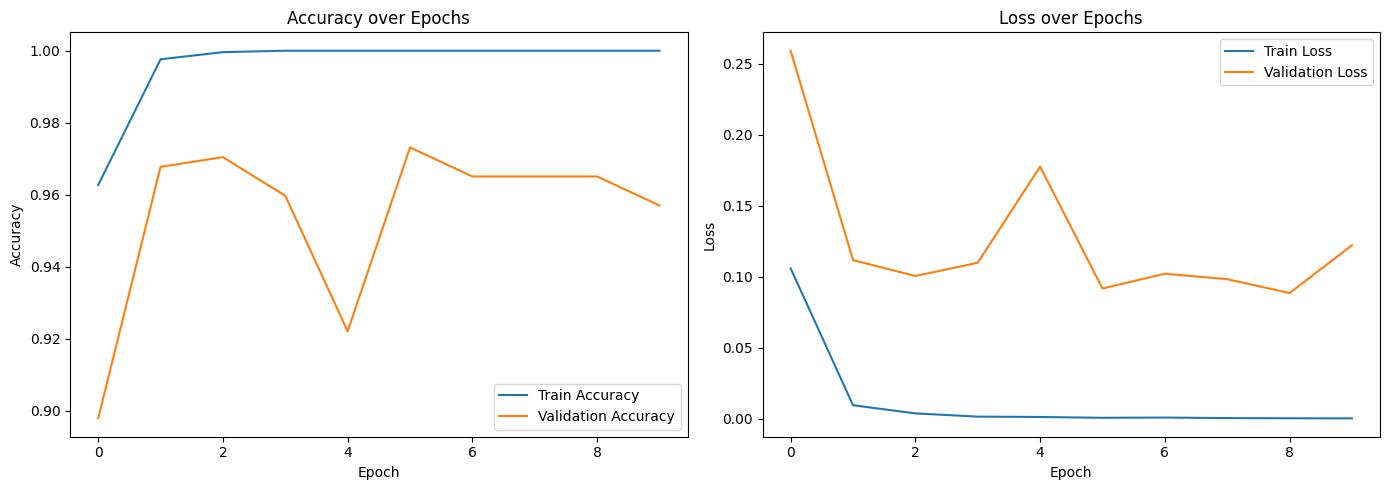

In [38]:
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Step 7: Evaluate the Model on Test Set

We evaluate the final model on the test set to report overall test accuracy and loss.

In [39]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_ds)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")
print(f"❌ Test Loss: {test_loss:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9557 - loss: 0.1042

✅ Test Accuracy: 0.9570
❌ Test Loss: 0.1221


## Step 8: Predict on Test Images

We predict labels for all test images and prepare the results for visualization and analysis.

In [40]:
# Unbatch test dataset to get all individual images and labels
all_images = []
all_labels = []

for image, label in test_ds.unbatch():
    all_images.append(image.numpy())
    all_labels.append(label.numpy())

all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Predict using the model
pred_probs = model.predict(all_images)
pred_labels = np.argmax(pred_probs, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 269ms/step


## Step 9: Visualize Predictions vs. True Labels

We display a few test images along with the model's predicted and true labels to inspect correctness visually.

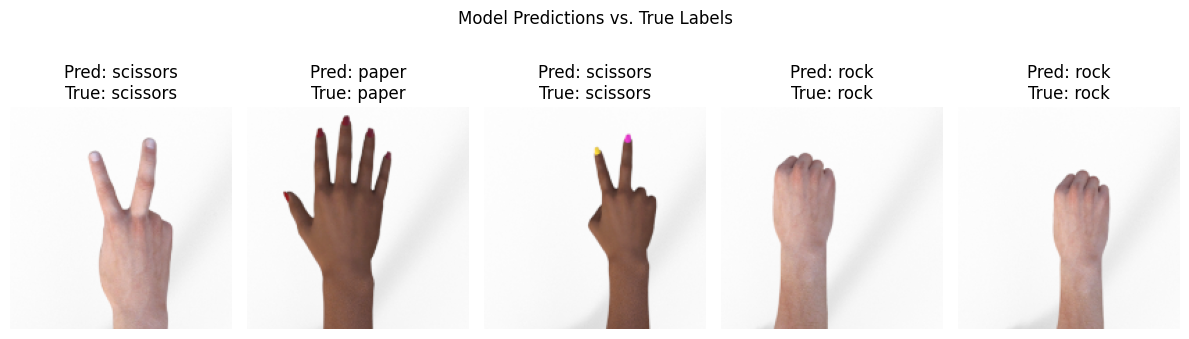

In [41]:
class_names = info.features['label'].names

plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(all_images[i])
    plt.title(f"Pred: {class_names[pred_labels[i]]}\nTrue: {class_names[all_labels[i]]}")
    plt.axis('off')
plt.suptitle("Model Predictions vs. True Labels")
plt.tight_layout()
plt.show()

## Step 10: Confusion Matrix

The confusion matrix summarizes model performance by showing correct and incorrect predictions across all classes.

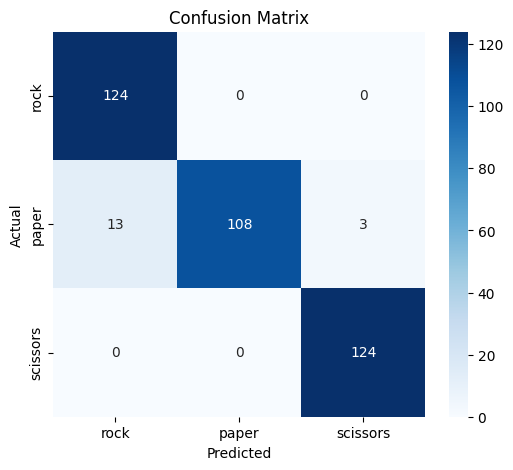

In [42]:
cm = confusion_matrix(all_labels, pred_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Step 11: Classification Report

We generate precision, recall, and F1-score for each class using scikit-learn’s classification report.

In [43]:
print("Classification Report:\n")
print(classification_report(all_labels, pred_labels, target_names=class_names))

Classification Report:

              precision    recall  f1-score   support

        rock       0.91      1.00      0.95       124
       paper       1.00      0.87      0.93       124
    scissors       0.98      1.00      0.99       124

    accuracy                           0.96       372
   macro avg       0.96      0.96      0.96       372
weighted avg       0.96      0.96      0.96       372

